**Brian Blaylock**  
**April 4, 2019**

# **Fig. 7** Hovemoller Scores

![](./figs/Fig-07a_HOV_skill_HRRR.png)

> Caption

NOTE: Probability of Detection (POD) is the same thing as Hit Rate (HR)  
NOTE: Equitable Threat Score (ETS) is the same thing as Gilbert Skill Score (GSS)

In [235]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os
from matplotlib.path import Path

import itertools

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [6.5, 3.5]
mpl.rcParams['figure.titlesize'] = 10
mpl.rcParams['figure.titleweight'] = 'bold'
mpl.rcParams['xtick.labelsize'] = 6
mpl.rcParams['ytick.labelsize'] = 6
mpl.rcParams['axes.labelsize'] = 6
mpl.rcParams['axes.titlesize'] = 8
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['grid.linewidth'] = .25
mpl.rcParams['figure.subplot.wspace'] = 0.05
mpl.rcParams['figure.subplot.hspace'] = 0.05
mpl.rcParams['legend.fontsize'] = 6
mpl.rcParams['legend.framealpha'] = .75
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['savefig.dpi'] = 600

In [137]:
import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3')
from BB_maps.my_basemap import draw_HRRR_map, draw_centermap
from BB_HRRR.HRRR_Pando import get_hrrr_latlon, get_hrrr_variable
from BB_HRRR.GLM_and_HRRR.GLM_events_HRRR import get_GLM_HRRR_contingency_stats,\
                                                 hit_rate, \
                                                 false_alarm_ratio, \
                                                 equitable_threat_score,\
                                                 proportion_correct, \
from BB_GOES.get_GLM import get_GLM_file_nearesttime, accumulate_GLM_FAST

In [200]:
sDATE = datetime(2018, 7, 13)
eDATE = datetime(2018, 9, 1)

file_dates = [datetime(2018, m, 1) for m in range(sDATE.month, eDATE.month+1)]
for hour in range(2):
    mean_POD = []
    mean_FAR = []
    mean_ETS = []

    DIR = '/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_HRRR/GLM_and_HRRR/HRRR_GLM_contingency_table'
    files = []
    for DATE in file_dates:
        FILE = '/%s/%s_2018_m%02d_h%02d.csv' % (DOMAIN, DOMAIN, DATE.month, hour)
        files.append(DIR+FILE)

    data = [np.genfromtxt(FILE, delimiter=',', names=True, dtype=None, encoding='UTF-8') for FILE in files]

    dates = np.array(list(itertools.chain(*[data[i]['DATE'] for i in range(len(files))])))
    DATES = np.array([])
    for D in dates:
        try:
            DATES = np.append(DATES, datetime.strptime(D, '%Y-%m-%d %H:%M:%S'))
        except:
            DATES = np.append(DATES, datetime.strptime(D, '%m/%d/%Y %H:%M'))
    date_boolean = np.array([np.logical_and(D>=sDATE, D<eDATE) for D in DATES])
    DATES = DATES[date_boolean]

    EVENTS = np.array(list(itertools.chain(*[data[i]['GLM_Event_COUNT'] for i in range(len(files))])))
    EVENTS = EVENTS[date_boolean]
    

50
50


In [201]:
def get_traditional_scores(sDATE, eDATE, DOMAIN):
    file_dates = [datetime(2018, m, 1) for m in range(sDATE.month, eDATE.month+1)]
    samples = []
    for hour in range(24):
        mean_POD = []
        mean_FAR = []
        mean_ETS = []

        DIR = '/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_HRRR/GLM_and_HRRR/HRRR_GLM_contingency_table'
        files = []
        for DATE in file_dates:
            FILE = '/%s/%s_2018_m%02d_h%02d.csv' % (DOMAIN, DOMAIN, DATE.month, hour)
            files.append(DIR+FILE)

        data = [np.genfromtxt(FILE, delimiter=',', names=True, dtype=None, encoding='UTF-8') for FILE in files]

        dates = np.array(list(itertools.chain(*[data[i]['DATE'] for i in range(len(files))])))
        DATES = np.array([])
        for D in dates:
            try:
                DATES = np.append(DATES, datetime.strptime(D, '%Y-%m-%d %H:%M:%S'))
            except:
                DATES = np.append(DATES, datetime.strptime(D, '%m/%d/%Y %H:%M'))
        date_boolean = np.array([np.logical_and(D>=sDATE, D<eDATE) for D in DATES])
        DATES = DATES[date_boolean]
        samples.append(len(DATES))
        
        EVENTS = np.array(list(itertools.chain(*[data[i]['GLM_Event_COUNT'] for i in range(len(files))])))
        EVENTS = EVENTS[date_boolean]

        for f in range(1,19):
            # Get A, B, C, D values for dates within requested DATES with date_boolean
            A = np.array(list(itertools.chain(*[data[i]['F%02d_A' % f] for i in range(len(files))])))[date_boolean]
            B = np.array(list(itertools.chain(*[data[i]['F%02d_B' % f] for i in range(len(files))])))[date_boolean]
            C = np.array(list(itertools.chain(*[data[i]['F%02d_C' % f] for i in range(len(files))])))[date_boolean]
            D = np.array(list(itertools.chain(*[data[i]['F%02d_D' % f] for i in range(len(files))])))[date_boolean]

            mean_POD.append(np.nanmean(hit_rate(A, B, C, D)))
            mean_FAR.append(np.nanmean(false_alarm_ratio(A, B, C, D)))
            mean_ETS.append(np.nanmean(equitable_threat_score(A, B, C, D)))

        if hour == 0:
            mean_POD_HOV = np.array(mean_POD)
            mean_FAR_HOV = np.array(mean_FAR)
            mean_ETS_HOV = np.array(mean_ETS)
        else:
            mean_POD_HOV = np.vstack([mean_POD_HOV, mean_POD])
            mean_FAR_HOV = np.vstack([mean_FAR_HOV, mean_FAR])    
            mean_ETS_HOV = np.vstack([mean_ETS_HOV, mean_ETS])    

    return {'POD': np.transpose(mean_POD_HOV),
            'FAR': np.transpose(mean_FAR_HOV),
            'ETS': np.transpose(mean_ETS_HOV),
            'DATES': DATES,
            'EVENTS': EVENTS,
            'SAMPLES': samples}

In [202]:
def get_fss_scores(sDATE, eDATE, DOMAIN, radius):
    file_dates = [datetime(2018, m, 1) for m in range(sDATE.month, eDATE.month+1)]
    samples = []
    for hour in range(24):
        mean_FSS = []

        DIR = '/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_HRRR/GLM_and_HRRR/HRRR_GLM_Fractions_Skill_Score_r%02d/' % radius
        files = []
        for DATE in file_dates:
            FILE = '/%s/%s_2018_m%02d_h%02d.csv' % (DOMAIN, DOMAIN, DATE.month, hour)
            files.append(DIR+FILE)

        data = [np.genfromtxt(FILE, delimiter=',', names=True, dtype=None, encoding='UTF-8') for FILE in files]

        dates = np.array(list(itertools.chain(*[data[i]['DATE'] for i in range(len(files))])))
        DATES = np.array([])

        for D in dates:
            try:
                DATES = np.append(DATES, datetime.strptime(D, '%Y-%m-%d %H:%M:%S'))
            except:
                DATES = np.append(DATES, datetime.strptime(D, '%m/%d/%Y %H:%M'))
        date_boolean = np.array([np.logical_and(D>=sDATE, D<eDATE) for D in DATES])
        DATES = DATES[date_boolean]
        samples.append(len(DATES))

        for f in range(1,19):
            # Get A, B, C, D values for dates within requested DATES with date_boolean
            FSS = np.array(list(itertools.chain(*[data[i]['F%02d_FSS' % f] for i in range(len(files))])))[date_boolean]
            mean_FSS.append(np.nanmean(FSS))

        if hour == 0:
            mean_FSS_HOV = np.array(mean_FSS)
        else:
            mean_FSS_HOV = np.vstack([mean_FSS_HOV, mean_FSS])

    return {'FSS': np.transpose(mean_FSS_HOV),
            'DATES': DATES,
            'SAMPLES': samples}

Working on HRRR 2018-07-13 00:00:00 2018-09-01 00:00:00
saved: HRRR 7
Working on West 2018-07-13 00:00:00 2018-09-01 00:00:00


/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_wx_calcs/binary_events.py:152: RuntimeWarning: invalid value encountered in true_divide
  FAR = b/(a+b)
/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_wx_calcs/binary_events.py:125: RuntimeWarning: invalid value encountered in true_divide
  H = a/(a+c)
/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_wx_calcs/binary_events.py:226: RuntimeWarning: invalid value encountered in true_divide
  GSS = (a-a_r)/(a+b+c-a_r)


saved: West 7
Working on Central 2018-07-13 00:00:00 2018-09-01 00:00:00
saved: Central 7
Working on East 2018-07-13 00:00:00 2018-09-01 00:00:00
saved: East 7
Sta Date: 0100 UTC 13 July 2018
End Date: 0100 UTC 31 August 2018
Contingency Table Samples: 50
       FSS Scores Samples: 50


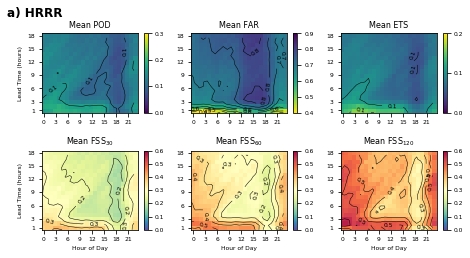

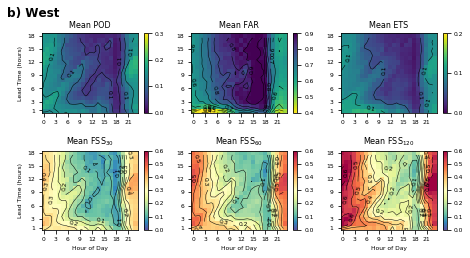

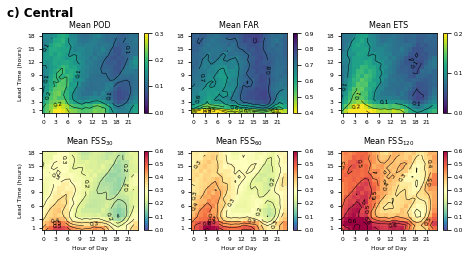

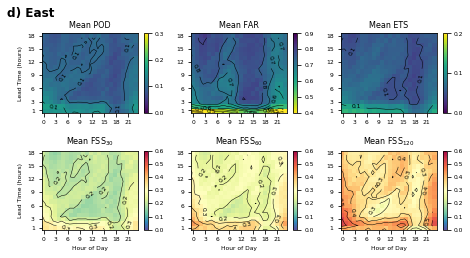

In [247]:
sDATE = datetime(2018, 7, 13)
eDATE = datetime(2018, 9, 1)

radii = [10, 20, 40]

domains = ['HRRR', 'West', 'Central', 'East']
labels = ['a)', 'b)', 'c)', 'd)']

#for DOMAIN, label in zip(['HRRR'], ['a)']):
for DOMAIN, label in zip(domains, labels):
    print('Working on %s %s %s' % (DOMAIN, sDATE, eDATE))
    CT = get_traditional_scores(sDATE, eDATE, DOMAIN)
    FSS = {}
    for r in radii:
        FSS[r] = get_fss_scores(sDATE, eDATE, DOMAIN, r)
        
    #        [ax, data, vmax, vmin, cmap, name]
    plots = [[0, CT['POD'], 0.3, 0, 'viridis', 'POD'], 
             [1, CT['FAR'], .9, .4, 'viridis_r', 'FAR'], 
             [2, CT['ETS'], .2, 0, 'viridis', 'ETS']]
    
    for idx, r in zip(range(3,3+len(radii)), radii):
        plots.append([idx, FSS[r]['FSS'], .6, 0, 'Spectral_r', r'FSS$\mathregular{_{%s}}$' % (r*3)])


    fig, axes = plt.subplots(2,3)
    axes = axes.flatten()

    for p in plots:
        ax, data, vmax, vmin, cmap, name = p
        plt.sca(axes[ax])
        plt.pcolormesh(range(25), range(1,20), data, vmax=vmax, vmin=vmin, cmap=cmap)
        plt.colorbar(pad=.05, ticks=np.arange(vmin, vmax+.01, .1))

        CS = plt.contour(range(24), range(1,19), data, colors='k', linewidths=.5, levels=np.arange(vmin-.1,vmax+1,.05))
        plt.clabel(CS, fmt='%1.1f', fontsize=6)

        plt.yticks(np.array([1, 3, 6, 9, 12, 15, 18])+.5, [1, 3, 6, 9, 12, 15, 18])
        plt.xticks(np.arange(0,24,3)+.5, range(0,24,3), )

        if ax in [0, 3]:
            plt.ylabel('Lead Time (hours)')
        
        if ax in [3, 4, 5]:
            plt.xlabel('Hour of Day')
            
        plt.title('Mean %s' % name)

    plt.suptitle('%s %s' % (label, DOMAIN), y=1.01, x=0, ha='left', fontsize=12)
    fig.tight_layout()

    plt.savefig('./figs/Fig-07%s_HOV_skill_%s.png' % (label[0],DOMAIN))
    print('saved:', DOMAIN, MONTH)

    #if DOMAIN != 'HRRR':
    #    plt.close()
        
print('Sta Date:', DATES[0].strftime('%H%M UTC %d %B %Y'))
print('End Date:', DATES[-1].strftime('%H%M UTC %d %B %Y'))

# Numnber of samples
print('Contingency Table Samples:', len(CT['DATES']))
print('       FSS Scores Samples:', len(FSS[10]['DATES']))

---
# Hovemollers Departure from HRRR
Compare a domains again the HRRR-wide statistics

Working on West 2018-07-13 00:00:00 2018-09-01 00:00:00


/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_wx_calcs/binary_events.py:152: RuntimeWarning: invalid value encountered in true_divide
  FAR = b/(a+b)
/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_wx_calcs/binary_events.py:125: RuntimeWarning: invalid value encountered in true_divide
  H = a/(a+c)
/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_wx_calcs/binary_events.py:226: RuntimeWarning: invalid value encountered in true_divide
  GSS = (a-a_r)/(a+b+c-a_r)


saved: West 7
Working on Central 2018-07-13 00:00:00 2018-09-01 00:00:00
saved: Central 7
Working on East 2018-07-13 00:00:00 2018-09-01 00:00:00


/uufs/chpc.utah.edu/common/home/u0553130/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


saved: East 7
Sta Date: 0100 UTC 13 July 2018
End Date: 0100 UTC 31 August 2018
Contingency Table Samples: 50
       FSS Scores Samples: 50


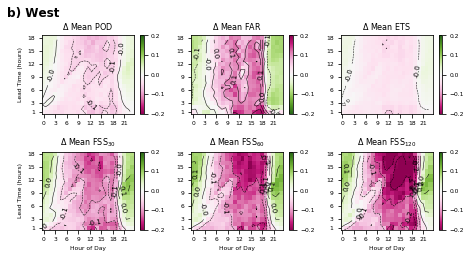

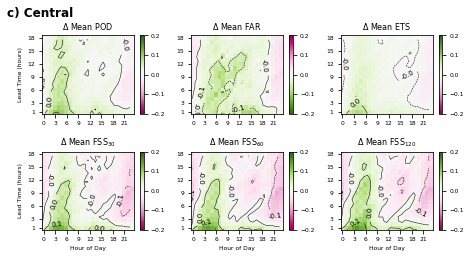

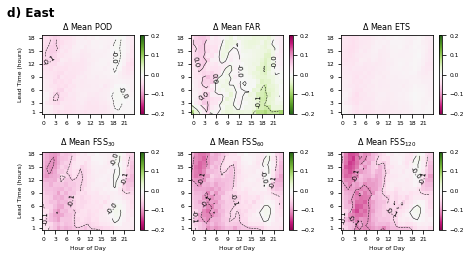

In [248]:
sDATE = datetime(2018, 7, 13)
eDATE = datetime(2018, 9, 1)

radii = [10, 20, 40]
reference_DOMAIN = 'HRRR'
domains = ['West', 'Central', 'East']
labels = ['b)', 'c)', 'd)']

for DOMAIN, label in zip(domains, labels):
    print('Working on %s %s %s' % (DOMAIN, sDATE, eDATE))
    
    # Scores for requested domain (subregion)
    CT = get_traditional_scores(sDATE, eDATE, DOMAIN)
    FSS = {}
    for r in radii:
        FSS[r] = get_fss_scores(sDATE, eDATE, DOMAIN, r)
    
    # Scores for reference domain (HRRR)
    CT_HRRR = get_traditional_scores(sDATE, eDATE, reference_DOMAIN)
    FSS_HRRR = {}
    for r in radii:
        FSS_HRRR[r] = get_fss_scores(sDATE, eDATE, reference_DOMAIN, r)
        
    #        [ax, data, vmax, vmin, cmap, name]
    plots = [[0, CT['POD']-CT_HRRR['POD'], .2, -.2, 'PiYG', 'POD'], 
             [1, CT['FAR']-CT_HRRR['FAR'], .2, -.2, 'PiYG_r', 'FAR'], 
             [2, CT['ETS']-CT_HRRR['ETS'], .2, -.2, 'PiYG', 'ETS']]
    
    for idx, r in zip(range(3,3+len(radii)), radii):
        plots.append([idx, FSS[r]['FSS']-FSS_HRRR[r]['FSS'], .2, -.2, 'PiYG', r'FSS$\mathregular{_{%s}}$' % (r*3)])


    fig, axes = plt.subplots(2,3)
    axes = axes.flatten()

    for p in plots:
        ax, data, vmax, vmin, cmap, name = p
        plt.sca(axes[ax])
        plt.pcolormesh(range(25), range(1,20), data, vmax=vmax, vmin=vmin, cmap=cmap)
        plt.colorbar(pad=.05, ticks=np.arange(vmin, vmax+.01, .1))

        CS = plt.contour(range(24), range(1,19), data, colors='k', linewidths=.5, levels=np.arange(vmin-.1,vmax+1,.05))
        plt.clabel(CS, fmt='%1.1f', fontsize=7)

        plt.yticks(np.array([1, 3, 6, 9, 12, 15, 18])+.5, [1, 3, 6, 9, 12, 15, 18])
        plt.xticks(np.arange(0,24,3)+.5, range(0,24,3), )

        if ax in [0, 3]:
            plt.ylabel('Lead Time (hours)')
        
        if ax in [3, 4, 5]:
            plt.xlabel('Hour of Day')
            
        plt.title(r'$\Delta$ Mean %s' % name)

    plt.suptitle('%s %s' % (label, DOMAIN), y=1.01, x=0, ha='left', fontsize=12)
    fig.tight_layout()

    plt.savefig('./figs/Fig-07%s_HOV_skill_%s_DIFF.png' % (label[0],DOMAIN))
    print('saved:', DOMAIN, MONTH)

    #if DOMAIN != 'HRRR':
    #    plt.close()
        
print('Sta Date:', DATES[0].strftime('%H%M UTC %d %B %Y'))
print('End Date:', DATES[-1].strftime('%H%M UTC %d %B %Y'))
        
# Numnber of samples
print('Contingency Table Samples:', len(CT['DATES']))
print('       FSS Scores Samples:', len(FSS[10]['DATES']))